In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

from sklearn import preprocessing
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler 

Link to the data source:

https://catalog.data.gov/dataset/crime-data-from-2010-to-present

Further reference:
http://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/

## Read data set file

In [2]:
df = pd.read_csv('la_2013_2018.csv', parse_dates=['datetime'])

df = df.set_index('datetime')

# Create columns with year, month, day, weekday and hour dummies:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

df = df[df['year']<2018]

In [3]:
df.head(3)

,district,crime_code,year,month,day,weekday,hour
datetime,,,,,,,
2013-03-11 18:00:00,1241,626,2013,3,11,0,18
2013-03-18 20:30:00,1823,510,2013,3,18,0,20
2014-01-04 23:00:00,2133,745,2014,1,4,5,23


## Create crime categories columns

Crimes were grouped according to four categories:
1. violent crime
2. personal crime
3. property crime
4. other crime and misdemeanors

In [4]:
# Create a district ranking column:
district  = df.district.value_counts()/len(df)*100
district = district.to_dict()

df['district_rkg'] = np.nan
for key, value in district.items():
    df.loc[(df['district'] == key), ['district_rkg']] = value

In [5]:
# Optionally, filter the top 25% districts with most crime:
df = df[df.district_rkg >0.22]

In [6]:
# Read file with categories (from 1 to 4) according to crime types:
cats = pd.read_excel('LA_crime_categories.xlsx',skiprows=4)

# Read the categories dataframe and create a dictionary with crime codes and categories:
crime_codes_dict = dict(zip(cats['Crime Code'], cats['category']))

# Create a column with event categories:
df['category'] = np.nan
for key, value in crime_codes_dict.items():
    df.loc[(df['crime_code'] == key), ['category']] = value

# Create event category dummy columns and drop unnecessary columns:
dfCC = pd.get_dummies(df.category)
frames = [df,dfCC]
df = pd.concat(frames, axis=1)
df.drop(columns=['category','crime_code'],inplace=True)

## Visualize correlations

In [7]:
# Generate correlation matrix:
corr_matrix = df.corr()

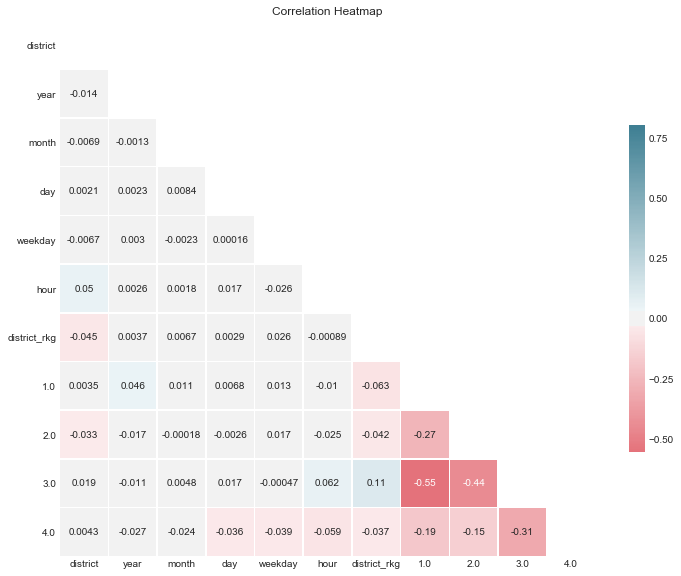

In [8]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

## Rank month, day, weekday and hour variables

Since crime trends can vary between districts, calculate separate month, day, weekday, and hour rankings FOR EVERY DISTRICT.

In [9]:
df['month_rkg'] = np.nan
df['weekday_rkg'] = np.nan
df['day_rkg'] = np.nan
df['hour_rkg'] = np.nan

for i in df.district.unique():
    month  = df.loc[df.district==i].month.value_counts()/df.loc[df.district==i].month.count()
    month = month.to_dict()
    for key, value in month.items():
        df.loc[(df.district==i) & (df.month == key), ['month_rkg']] = value
        
    weekday  = df.loc[df.district==i].weekday.value_counts()/df.loc[df.district==i].weekday.count()
    weekday = weekday.to_dict()
    for key, value in weekday.items():
        df.loc[(df.district==i) & (df.weekday == key), ['weekday_rkg']] = value

    day = df.loc[df.district==i].day.value_counts()/df.loc[df.district==i].day.count()
    day = day.to_dict()
    for key, value in day.items():
        df.loc[(df.district==i) & (df.day == key), ['day_rkg']] = value

    hour = df.loc[df.district==i].hour.value_counts()/df.loc[df.district==i].hour.count()
    hour = hour.to_dict()
    for key, value in hour.items():
        df.loc[(df.district==i) & (df.hour == key), ['hour_rkg']] = value

In [10]:
df.head(3)

,district,year,month,day,weekday,hour,district_rkg,1.0,2.0,3.0,4.0,month_rkg,weekday_rkg,day_rkg,hour_rkg
datetime,,,,,,,,,,,,,,,
2013-03-11 18:00:00,1241,2013,3,11,0,18,0.268073,0,1,0,0,0.087788,0.143363,0.029027,0.052035
2013-03-18 20:30:00,1823,2013,3,18,0,20,0.230780,0,0,1,0,0.086760,0.145559,0.033306,0.058799
2013-01-08 14:00:00,111,2013,1,8,1,14,0.268642,1,0,0,0,0.081243,0.148004,0.028259,0.054045


## Check for class imbalance

The general balance of our target variable is close to 50/50 in the entire dataframe...

In [11]:
df[3.0].value_counts()

0    75947
1    70371
Name: 3.0, dtype: int64

... but the balance will vary widely within districts. **Therefore, resampling needs to be done for each district.**

In [12]:
df[df.district==162][3.0].value_counts()

1    1843
0    1184
Name: 3.0, dtype: int64

## Run the Logistic, Lasso, and Ridge regressions

Data will be resampled and regressions will be fit for every district.

In [13]:
# List of unique districts:
districts = df.district.unique()

In [14]:
# Fit the LOGIT regression classifier for five districts:

for i in districts[5:10]:
    
    # Select district data subset:
    X_train = df[(df.district==i) & (df.year<2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_train = df[(df.district==i) & (df.year<2017)][3.0]
    
    X_test = df[(df.district==i) & (df.year==2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_test = df[(df.district==i) & (df.year==2017)][3.0]
    
    # Random over sample district subset for training purposes:
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    # Call and fit the model:
    lr = LogisticRegression(C=10)
    fit = lr.fit(X_resampled, y_resampled)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    y_pred = lr.predict(X_test)

    print('\n Accuracy')
    print(pd.crosstab(y_pred, y_test))

    print('\n Percentage accuracy')
    print(lr.score(X_test, y_test))


---------
DISTRICT: 156

Coefficients
[[-0.09043384 -0.56668099  3.68111341 -0.76628453 -1.31736519]]
[-0.37757814]

 Accuracy
3.0      0    1
row_0          
0      244   62
1      258  105

 Percentage accuracy
0.5216741405082213

---------
DISTRICT: 152

Coefficients
[[-0.12619933  1.00249416  0.78439923 -1.7900862   7.3904977 ]]
[-0.47361468]

 Accuracy
3.0      0    1
row_0          
0      214  145
1      153  190

 Percentage accuracy
0.5754985754985755

---------
DISTRICT: 153

Coefficients
[[ 0.03430953 -0.32708972 -1.21278778 -0.76541111  1.52556087]]
[0.1481195]

 Accuracy
3.0      0    1
row_0          
0      164   90
1      152  115

 Percentage accuracy
0.5355086372360844

---------
DISTRICT: 1494

Coefficients
[[ 0.07726882 -0.21194529 -2.60919418 -0.43710549  3.75203179]]
[0.2005596]

 Accuracy
3.0      0    1
row_0          
0       95  306
1      169  418

 Percentage accuracy
0.5192307692307693

---------
DISTRICT: 395

Coefficients
[[ 0.07553586 -0.85245913  1.601

In [15]:
# Fit the LASSO regression classifier for five districts:

for i in districts[5:10]:
    
    # Select district data subset:
    X_train = df[(df.district==i) & (df.year<2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_train = df[(df.district==i) & (df.year<2017)][3.0]
    
    X_test = df[(df.district==i) & (df.year==2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_test = df[(df.district==i) & (df.year==2017)][3.0]
    
    # Random over sample district subset for training purposes:
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    # Call and fit the model:
    lr = LogisticRegression(penalty='l1')
    fit = lr.fit(X_resampled, y_resampled)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    y_pred = lr.predict(X_test)

    print('\n Accuracy')
    print(pd.crosstab(y_pred, y_test))

    print('\n Percentage accuracy')
    print(lr.score(X_test, y_test))


---------
DISTRICT: 156

Coefficients
[[0. 0. 0. 0. 0.]]
[0.]

 Accuracy
3.0      0    1
row_0          
0      502  167

 Percentage accuracy
0.750373692077728

---------
DISTRICT: 152

Coefficients
[[0.         0.         0.         0.         5.41525459]]
[-0.26915188]

 Accuracy
3.0      0    1
row_0          
0      206  143
1      161  192

 Percentage accuracy
0.5669515669515669

---------
DISTRICT: 153

Coefficients
[[0. 0. 0. 0. 0.]]
[0.]

 Accuracy
3.0      0    1
row_0          
0      316  205

 Percentage accuracy
0.6065259117082533

---------
DISTRICT: 1494

Coefficients
[[0. 0. 0. 0. 0.]]
[0.]

 Accuracy
3.0      0    1
row_0          
0      264  724

 Percentage accuracy
0.26720647773279355

---------
DISTRICT: 395

Coefficients
[[ 0.          0.          0.          0.         -8.95931198]]
[0.41118211]

 Accuracy
3.0      0    1
row_0          
0      188  104
1       99   81

 Percentage accuracy
0.5699152542372882


In [16]:
# Fit the RIDGE regression classifier for five districts:

for i in districts[5:10]:
    
    # Select district data subset:
    X_train = df[(df.district==i) & (df.year<2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_train = df[(df.district==i) & (df.year<2017)][3.0]
    
    X_test = df[(df.district==i) & (df.year==2017)][['district_rkg','month_rkg',
                 'weekday_rkg', 'day_rkg', 'hour_rkg']]
    y_test = df[(df.district==i) & (df.year==2017)][3.0]
    
    # Random over sample district subset for training purposes:
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    # Call and fit the model:
    lr = LogisticRegression(penalty='l2')
    fit = lr.fit(X_resampled, y_resampled)

    # Display_temp.
    print('\n---------\nDISTRICT:',i)
    print('\nCoefficients')
    print(fit.coef_)
    print(fit.intercept_)
    y_pred = lr.predict(X_test)

    print('\n Accuracy')
    print(pd.crosstab(y_pred, y_test))

    print('\n Percentage accuracy')
    print(lr.score(X_test, y_test))


---------
DISTRICT: 156

Coefficients
[[-0.01852616 -0.07470336  0.70041021 -0.09821627 -0.21555582]]
[-0.07735017]

 Accuracy
3.0      0    1
row_0          
0      244   62
1      258  105

 Percentage accuracy
0.5216741405082213

---------
DISTRICT: 152

Coefficients
[[-0.02507953  0.15546038  0.08847988 -0.19705737  1.63353424]]
[-0.0941212]

 Accuracy
3.0      0    1
row_0          
0      215  146
1      152  189

 Percentage accuracy
0.5754985754985755

---------
DISTRICT: 153

Coefficients
[[ 0.00366132 -0.03902254 -0.15930628 -0.08669883  0.26632038]]
[0.01580646]

 Accuracy
3.0      0    1
row_0          
0      163   93
1      153  112

 Percentage accuracy
0.527831094049904

---------
DISTRICT: 1494

Coefficients
[[ 0.00896813 -0.04736897 -0.41627382 -0.0470378   0.81989416]]
[0.02327776]

 Accuracy
3.0      0    1
row_0          
0       90  269
1      174  455

 Percentage accuracy
0.5516194331983806

---------
DISTRICT: 395

Coefficients
[[ 0.01411965 -0.12876138  0.236